In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Real-time FFT

* **Course AIS2201 - Signal Processing**
* **Week 39, 2024**
* **Lecturer: Kai Erik Hoff**

# Topics

* Hardware Timers
* Direct Memory Access (DMA)
* Pointers and Arrays in `C`
* Using the DSP Library
* The FFT function(s)

# Real-time DFT challenges

* As the DFT is calculated using "blocks" of $N$ signal samples at a time, the DFT must be calculated once every $N$ sample periods.



* All samples acquired between "windows" must be stored in a buffer

* The ADC must be able to continue converting samples for the next window while the FFT is processing the preceding window.

* *But first: using Hardware Timers to control Sampling Frequency $fs$*

# What are Hardware Timers?

* Digital circuits which can count clock cycles.
    * This is done in a "Counting Register" (`TIMx_CNT`).

* Counting is reset once `TIMx_CNT` reaches a predetermined value.
    * Reset intervals determined by the "Auto Reload Register" (`TIMx_ARR`)

* Can be configured to:
    * Generate a specific output every `TIMx_ARR` clock cycles
    * Measure number of clock cycles between between changes in logical signal

# What are hardware timers used for?

* Controlling Serial communication
    * Serial data is transmitted at a certain "Baud Rate"

* Generating PWM Output
    * A PWM duty cycle repeats every `TIMx_ARR` cycles, and has a pulse width of `TIMx_CCRy` cycles

* Measuring "timed" input
    * Certain sensors use e.g. "rise time" for a capacitor voltage as metric.
    * Can be measured with a hardware timer without "pausing" the program.

* Triggering hardware actions at certain intervals
    * Primary example: sampling with an ADC
        * Timer generates an internal signal, which we can use to initiate an A/D convertion on an ADC

## Timer operation illustrated

Text(0, 0.5, '$v_{out}$')

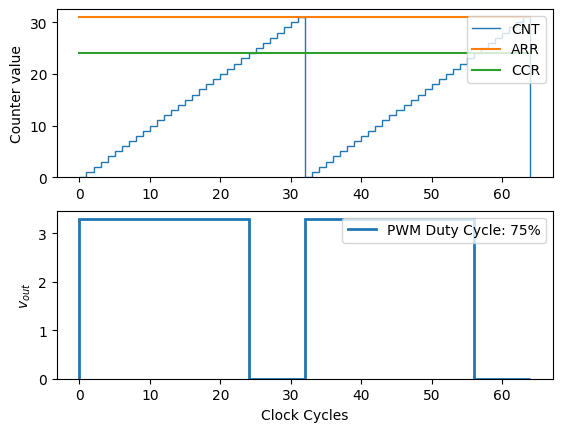

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Register settings
ARR = 31
CCR = 24

# Generating PWM output
n = np.arange(0, (ARR+1)*2)  # Generate 2 cycles of output
cnt_val = n % (ARR + 1)  # Counting starts over from ARR (inclusive)
pwm_sig = np.where(cnt_val < CCR, 3.3, 0)  # PWM Output is HIGH while cnt_val < CCR 

# Visualizing PWM output
plt.subplot(2,1,1)
plt.stairs(cnt_val, label="CNT")
plt.plot([0, len(n)], [ARR, ARR], label="ARR")
plt.plot([0, len(n)], [CCR, CCR], label="CCR")
plt.legend(loc="upper right")
plt.ylabel("Counter value")
plt.subplot(2,1,2)
plt.stairs(pwm_sig, linewidth=2, label=f"PWM Duty Cycle: {int(CCR/(ARR+1)*100)}%")
plt.legend(loc="upper right")
plt.xlabel("Clock Cycles")
plt.ylabel("$v_{out}$")

# Direct Memory Access

* What is DMA?
>"DMA is a bus master and system peripheral providing high-speed data transfers between peripherals and memory, as well as memory-to-memory.
Data can be quickly moved by DMA without any CPU action, keeping CPU resources free for other operations."
>
*Source: [wiki.st.com](https://wiki.st.com/stm32mcu/wiki/Getting_started_with_DMA)* 

* Using DMA, the ADC can write a constant stream of input samples to memory without requiring any CPU action.
    * DMA Bus width is `32` bit (4 bytes).
    * Given information on buffer location and buffer size, the DMA strema can write directly to the memory set aside as buffer.
    * DMA buffer can be configured as `circular` or `normal`.
    * Buffer allocation is achieved using `arrays`.

* DMA can trigger interrupts once the buffer is overwritten.

# Arrays in `C`


* Used to store a sequence of values of a certain type:
```C
int my_array[] = {1, 2, 3, 4, 5}; // Declares an array of length 5 with integer values 1-5
```

* Since datatype `int` is 2 bytes, the above declaration of `my_array` will allocate $5\cdot 2 = 10$ bytes for storage of array values.

* Array elements are accessed using indexing:
```C
int value_at_2 = my_array[2];
```

* Indexing out of bounds will not be prevented by compiler. The following will run without errors:
```C
int mystery_value = my_array[5]; // Acquires whatever is stored "next to" the array in system memory, and casts to 'int'
```

# Pointers in `C`

* A pointer is a reference to the memory location where a value is stored.<br>**Quick overview:**
```C
int my_value = 10;  // Declares integer variable
int *value_ptr = &my_value;  // Creates pointer variable wich contains address for 'my_value' (eg. 0xd2e6eea4)
int new_value = *value_ptr;  // Extracts value stored in address referenced by 'value_ptr' (i.e. 10)
/* The variable 'new_value' is now equal to 10 */ 
```

* Pointers allow functions to edit variables which are fed as input.<br>
```C
/* Example function description */
void increment(int* x){
    *x = *x + 1;
}

/* Example function call */
void main() {
    int my_value = 10;
    increment(&my_value);
    printf("%d", my_value); // Prints '11'
}
```

# Arrays are pointers!

* An array variable declared using `[]` simply contains a pointer to the location of the first element in the array.
    * Indexing becomes equivalent to incrementing the pointer addreess:
>```C
>int my_array[] = {1, 2, 3, 4, 5}; // Declares an array of length 5 with integer values 1-5
>int a = my_array[3]; // Assigns value at index 3 to variable 'a'
>int b = *(my_array + 3); // Assigns integer stored at address 'my_array + 3' to variable b 
>printf("%d %d", a, b); // Prints '4 4'
>```

* Functions processing arrays use pointers.
    * To avoid out-of-bounds errors, information about array size must be passed as well.
>```C
void square(int* x, int* y, int size){
    for (int i=0; i<size; i++){
        y[i] = x[i]*x[i];
    }
}
>void main() {
    int my_array[] = {1, 2, 3, 4, 5}; // Declares an array of length 5 with integer values 1-5
    int out_array[5] = {}; // Allocate memory for output array
    square(my_array, out_array, 5); // Compute elementwise squared
    printf("%d^2 = %d", my_array[2], out_array[2]); // Prints 3^2 = 9
}
>```

* Arrays can be cast to different types (*Not generally advisable, but common practice when using DMA.*)
>```C
uint32_t my_array[] = {0x1111aaaa}; // Declares an array of length 5 with integer values 1-5
uint16_t* array_copy = (uint16_t*) my_array; 
printf("%x %x", array_copy[1], array_copy[0]); // Prints '1111 aaaa'
>```

# CMSIS-DSP Library

* [ARM](https://en.wikipedia.org/wiki/ARM_Architecture_(company)) have provided a library with useful math and DSP functions

* Full library part of firmware package installed with CubeMX
    * Location: `<install_directory>\STM32Cube\Repository\STM32Cube_FW_Fx_Vx.xx.x\Drivers\CMSIS\DSP`

* Processes *entire arrays*.
    * Allocate space for input *and* output in separate arrays, then pass both input and output to function.
    * Example using [arm_abs_f32](https://arm-software.github.io/CMSIS_5/DSP/html/group__BasicAbs.html#ga0e8fc7df3033cdbe9cda8a766a46e6d9):
>```C
>float32_t input[2] = {-5, 5};
>float32_t outpu[2] = {};
>arm_abs_f32(input, output, 2);
>```

* Include instructions found [here](https://community.st.com/t5/stm32-mcus/how-to-integrate-cmsis-dsp-libraries-on-a-stm32-project/ta-p/666790)

# Double Buffering

* Overall program structure for handling sample stream in "batches"

<img src="Figurer/08_Effektspekter_Spektrogram/DualBufferAnim.gif" width="80%" style="margin-left:100px" />

* Total sample buffer size must be $2\times$ FFT window size

* Alternating halves of the `ADC_buffer` are copied to FFT input.

# FFT on an STM32





* Makes use of "basic" fft algorithms such as *radix-2*.
    * Divide and conquer algorithm expexts window size $N=2^k, k \in \mathbb{Z}$
    * Due to hardware limitations, FFT will only work for window sizes $N \in \{16, 32, 64, 128, 256, 512, 1024, 2048, 4096\}$

* FFT functions found in folder `TransformFunctions`
    * Requires inclusion of `"arm_const_structs.h"` in addition to `"arm_math.h"`

* An FFT-algorithm `struct` instance must be initialized before calculating FFT
    * Accomplished with separate `init`-function
    * Window size is determined here!
    * Allocates memory needed 

* Choose between `cfft` and `rfft`.
    * `cfft` produces two-sided DFT. <br>Expects complex input.
    * `rfft` produces one-sided DFT. <br>Expects real-valued input.

* Separate functions for different data types:
    * Floating-point: `f16`, `f32`, `f64`
    * Fixed-point: `q15`, `q31`
    * Example: `arm_cfft_f32` for calculating two-sided DFT with 32-bit floating point values.

## Example:

```C
/* Parameters */
uint32_t fftSize = 1024;
uint32_t ifftFlag = 0;
uint32_t doBitReverse = 1;

/* Create struct for computing CFFT */
arm_cfft_instance_f32 varInstCfftF32;

/* Initialize FFT struct */
arm_cfft_init_f32(&varInstCfftF32,fftSize);

/* Process the data through the CFFT/CIFFT module 
 Take note: the data in 'testInput_f32_10khz' is modified BY the function
 'arm_cfft_f32 and will contain the FFT output once the function has 
 executed.*/
arm_cfft_f32(&varInstCfftF32, testInput_f32_10khz, ifftFlag, doBitReverse);
```